In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from gemseo.algos.parameter_space import ParameterSpace
from gemseo import from_pickle
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_oad_training.utils import draw_aircraft
from gemseo_oad_training.utils import AircraftConfiguration
import pandas as pd

configure_logger()

<RootLogger root (INFO)>

# Compute constraints

In [2]:
def build_constraints_dataframe(constraints, margins):
    """
    Construit un DataFrame récapitulatif des contraintes à partir des dictionnaires constraints et margins.

    Args:
        constraints (dict): Dictionnaire des contraintes avec seuil, facteur et signe.
        margins (dict): Dictionnaire des marges standardisées.

    Returns:
        pd.DataFrame: DataFrame récapitulatif.
    """
    data = []

    for key, params in constraints.items():
        M = margins[key]
        s = params['seuil']
        f = abs(params['factor'])
        pos = params['positive']

        if pos:
            v = s - M / f
        else:
            v = s + M / f

        status = 'Respectée' if M < 0 else 'Non respectée'

        data.append({
            'Contrainte': key,
            'Seuil': s,
            'Facteur abs': f,
            'Marge standardisée': M,
            'Valeur réelle': v,
            'Statut': status
        })

    return pd.DataFrame(data)

# Disciplines

In [3]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [4]:
# Create the design space
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [5]:
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [6]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [7]:
# Add the constraints
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [8]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=1)

    INFO - 13:02:59: *** Start UMDOScenario execution ***
    INFO - 13:02:59: UMDOScenario
    INFO - 13:02:59:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 13:02:59:    Formulation:
    INFO - 13:02:59:       MDO formulation: MDF
    INFO - 13:02:59:       Statistic estimation: Sampling
    INFO - 13:02:59:    Uncertain space:
    INFO - 13:02:59:       +------+--------------------------------------------+
    INFO - 13:02:59:       | Name |                Distribution                |
    INFO - 13:02:59:       +------+--------------------------------------------+
    INFO - 13:02:59:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:02:59:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:02:59:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:02:59:       +------+--------------------------------------------+
    INFO - 

In [9]:
# scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [10]:
result = scenario.optimization_result
(result.constraint_values)

{'[Margin[tofl; 2.0]-1900.0]': array([-754.42151846]),
 '[Margin[vapp; 2.0]-69.44999999400001]': array([-12.4221709]),
 '-[Margin[vz; -2.0]-1.524]': array([-5.61276728]),
 '[Margin[span; 2.0]-40.0]': array([0.24922359]),
 '[Margin[length; 2.0]-45.0]': array([-8.]),
 '-Margin[fm; -2.0]': array([-1.15463282])}

In [12]:
constraints = {
    'tofl': {'seuil': 1900.0, 'factor': 2.0, 'positive': False},
    'vapp': {'seuil': 69.45, 'factor': 2.0, 'positive': False},
    'vz': {'seuil': 1.524, 'factor': -2.0, 'positive': True},
    'span': {'seuil': 40.0, 'factor': 2.0, 'positive': False},
    'length': {'seuil': 45.0, 'factor': 2.0, 'positive': False},
    'fm': {'seuil': 0.0, 'factor': -2.0, 'positive': True},
}


margins = {
    'tofl': -754.42151846,
    'vapp': -12.4221709,
    'vz': -5.61276728,
    'span': 0.24922359,
    'length': -8,
    'fm': -1.15463282,
}

build_constraints_dataframe(constraints, margins)

,Contrainte,Seuil,Facteur abs,Marge standardisée,Valeur réelle,Statut
0,tofl,1900.000,2.0,-754.421518,1522.789241,Respectée
1,vapp,69.450,2.0,-12.422171,63.238915,Respectée
2,vz,1.524,2.0,-5.612767,4.330384,Respectée
3,span,40.000,2.0,0.249224,40.124612,Non respectée
4,length,45.000,2.0,-8.000000,41.000000,Respectée
5,fm,0.000,2.0,-1.154633,0.577316,Respectée


# Import surrogate model

In [18]:
surrogate_disciplines = from_pickle("UC1_my_surrogate_3.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 28
   Surrogate model: RBFRegressor
   Inputs: aef, ar, area, cef, n_pax, sef, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create a new design space


In [19]:
design_space_surrogate = DesignSpace()
design_space_surrogate.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space_surrogate.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space_surrogate.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space_surrogate.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [20]:
uncertain_space_surrogate = ParameterSpace()
uncertain_space_surrogate.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [21]:
scenario_surrogate = UMDOScenario(
    [surrogate_disciplines],
    "mtom",
    design_space_surrogate,
    uncertain_space_surrogate,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

 WARNING - 12:28:01: No coupling in MDA, switching chain_linearize to True.
 WARNING - 12:28:01: No coupling in MDA, switching chain_linearize to True.


In [22]:
# Add the constraints
scenario_surrogate.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_surrogate.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [23]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 12:28:05: *** Start UMDOScenario execution ***
    INFO - 12:28:05: UMDOScenario
    INFO - 12:28:05:    Disciplines: RBF_Sampling
    INFO - 12:28:05:    Formulation:
    INFO - 12:28:05:       MDO formulation: MDF
    INFO - 12:28:05:       Statistic estimation: Sampling
    INFO - 12:28:05:    Uncertain space:
    INFO - 12:28:05:       +------+--------------------------------------------+
    INFO - 12:28:05:       | Name |                Distribution                |
    INFO - 12:28:05:       +------+--------------------------------------------+
    INFO - 12:28:05:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:28:05:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:28:05:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:28:05:       +------+--------------------------------------------+
    INFO - 12:28:05: Optimization problem:
    INFO - 12:28:05:    minimize E[mtom]
    INFO - 12:28:05:   

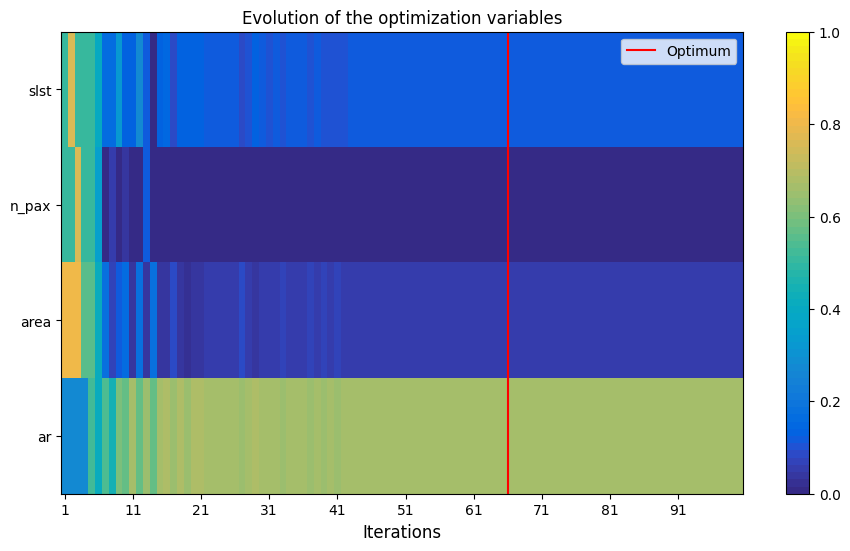

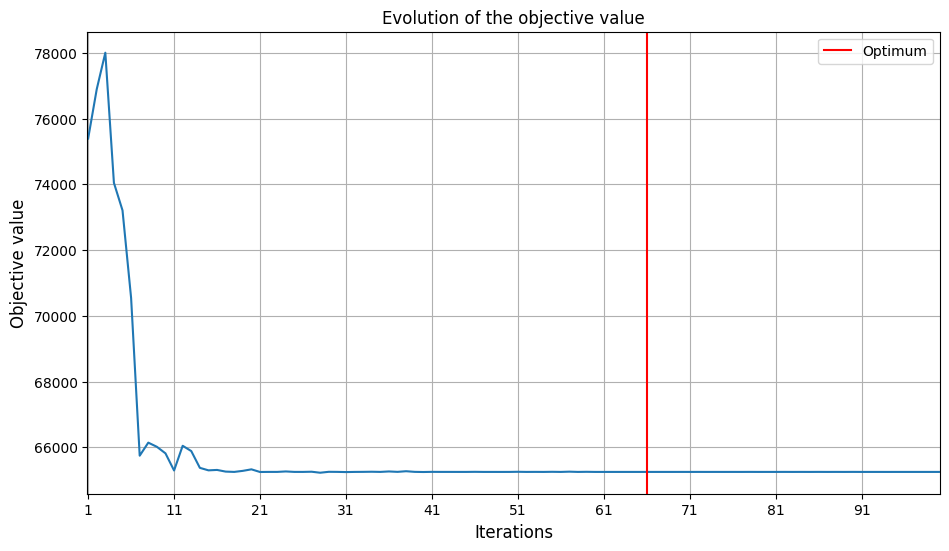

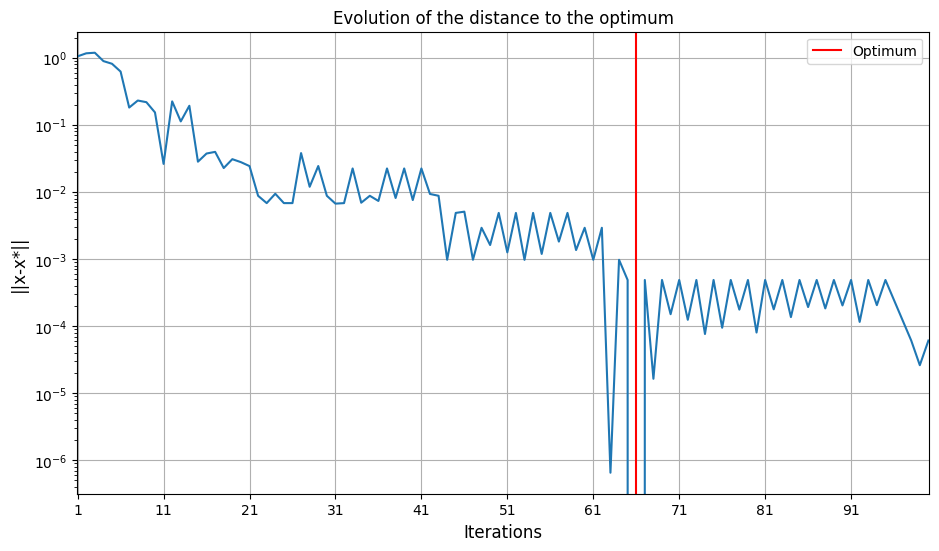

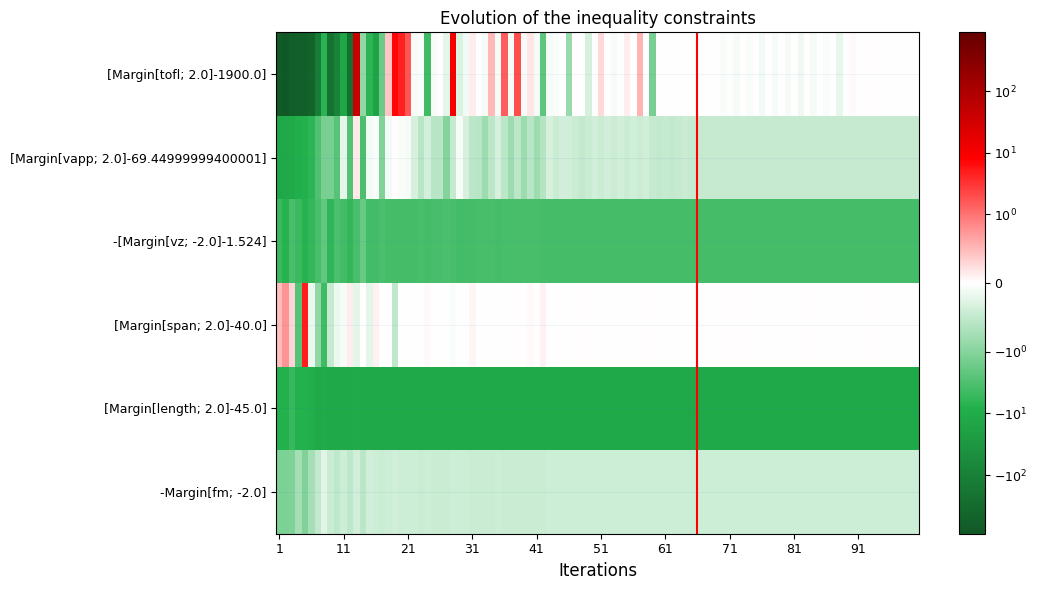

In [24]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluate surrogate optimum in the original model

## Compare results

In [25]:
scenario.optimization_result.x_opt_as_dict

{'slst': array([100000.]),
 'n_pax': array([120.]),
 'area': array([113.08177607]),
 'ar': array([14.14905262])}

## Evaluate optimum

In [26]:
scenario_surrogate.optimization_result.x_opt_as_dict

{'slst': array([111346.34623666]),
 'n_pax': array([120.]),
 'area': array([105.29592113]),
 'ar': array([14.93743494])}

In [27]:
scenario_test = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [28]:
# Add the constraints
scenario_test.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_test.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [29]:
scenario_test.execute(algo_name = 'CustomDOE', samples = [scenario_surrogate.optimization_result.x_opt_as_dict])

    INFO - 12:29:10: *** Start UMDOScenario execution ***
    INFO - 12:29:10: UMDOScenario
    INFO - 12:29:10:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 12:29:10:    Formulation:
    INFO - 12:29:10:       MDO formulation: MDF
    INFO - 12:29:10:       Statistic estimation: Sampling
    INFO - 12:29:10:    Uncertain space:
    INFO - 12:29:10:       +------+--------------------------------------------+
    INFO - 12:29:10:       | Name |                Distribution                |
    INFO - 12:29:10:       +------+--------------------------------------------+
    INFO - 12:29:10:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:29:10:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:29:10:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:29:10:       +------+--------------------------------------------+
    INFO - 

In [30]:
constraints_surrogate = {
    'tofl': {'seuil': 1900.0, 'factor': 2.0, 'positive': False},
    'vapp': {'seuil': 69.45, 'factor': 2.0, 'positive': False},
    'vz': {'seuil': 1.524, 'factor': -2.0, 'positive': True},
    'span': {'seuil': 40.0, 'factor': 2.0, 'positive': False},
    'length': {'seuil': 45.0, 'factor': 2.0, 'positive': False},
    'fm': {'seuil': 0.0, 'factor': -2.0, 'positive': True},
}


margins_surrogate = {
    'tofl': -49.59304793,
    'vapp': -0.92974071,
    'vz': -4.72441607,
    'span': -0.34081479,
    'length': -13.0,
    'fm': -0.43440804,
}

build_constraints_dataframe(constraints, margins)

,Contrainte,Seuil,Facteur abs,Marge standardisée,Valeur réelle,Statut
0,tofl,1900.000,2.0,4.462559e-05,1900.000022,Non respectée
1,vapp,69.450,2.0,-3.529324e+00,67.685338,Respectée
2,vz,1.524,2.0,-2.947457e+00,2.997728,Respectée
3,span,40.000,2.0,-4.282867e-10,40.000000,Respectée
4,length,45.000,2.0,-1.300000e+01,38.500000,Respectée
5,fm,0.000,2.0,-5.316886e-01,0.265844,Respectée


# Draw aircrafts

In [31]:
constraint_values = scenario.optimization_result.constraint_values
constraint_values_surrogate = scenario_surrogate.optimization_result.constraint_values

print("Constraints values for the original scenario:")
for name, value in constraint_values.items():
    print(f"{name}: {value}")
print("\nConstraints values for the surrogate scenario:")
for name, value in constraint_values_surrogate.items():
    print(f"{name}: {value}")

Constraints values for the original scenario:
[Margin[tofl; 2.0]-1900.0]: [4.46255858e-05]
[Margin[vapp; 2.0]-69.44999999400001]: [-3.52932442]
-[Margin[vz; -2.0]-1.524]: [-2.94745688]
[Margin[span; 2.0]-40.0]: [-4.28286739e-10]
[Margin[length; 2.0]-45.0]: [-13.]
-Margin[fm; -2.0]: [-0.53168864]

Constraints values for the surrogate scenario:
[Margin[tofl; 2.0]-1900.0]: [-7.22243385e-08]
[Margin[vapp; 2.0]-69.44999999400001]: [-0.46663347]
-[Margin[vz; -2.0]-1.524]: [-3.77254419]
[Margin[span; 2.0]-40.0]: [4.11617407e-09]
[Margin[length; 2.0]-45.0]: [-12.31691246]
-Margin[fm; -2.0]: [-0.42509848]


In [13]:
AC1 =AircraftConfiguration(name = 'x_base', length= 38.50, span = 40.000000, area = 113.0817760684979, color = 'blue')
AC2 =AircraftConfiguration(name = 'x_surrogate', length= 38.50, span = 40.00, area = 105.29, color = 'orange')
AC3 =AircraftConfiguration(name = 'x_default', length= 41, span = 40.12, area = 180, color = 'green')

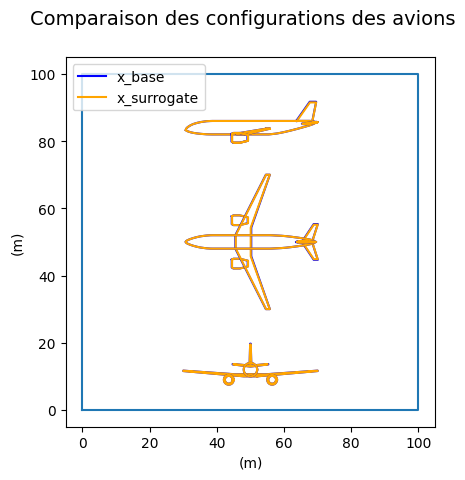

In [14]:
draw_aircraft(AC1, AC2, title="Comparaison des configurations des avions", save=False, show=True)

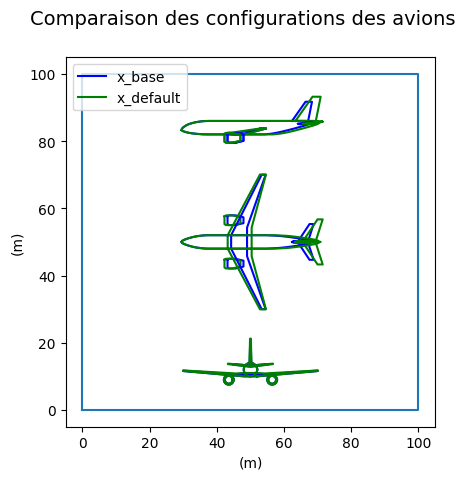

In [15]:
draw_aircraft(AC1, AC3, title="Comparaison des configurations des avions", save=False, show=True)